In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

In [3]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

/tmp/ipython-input-2538754208.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})


In [4]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Separate the data into DataLoaders

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the model and a training regimen

In [6]:
class ANN_CLASS(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear( 4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12, 3)

        # parameters
        self.dr = dropoutRate

        # forward pass
    def forward(self,x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()

        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x,p=self.dr,training=self.training)

        # output
        x = self.output(x)
        return x

In [7]:
# a function that creates the ANN model

def ANN_MODEL(dropoutrate):

    # grab an instance of the model class
    ANN = ANN_CLASS(dropoutrate)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005)

    return ANN,lossfunc,optim

In [8]:
# train the model

# global parameter
epochs = 1000

def train():

    # initialize accuracies as empties (not storing losses here)
    train_accuracy = []
    test_accuracy  = []

    # loop over epochs
    for i in range(epochs):

        # switch learning on
        ANN.train()

    # loop over training data batches
    batch_accuracy = []
    for X,y in train_loader:
        # forward pass and loss
        yHat = ANN(X)
        loss = lossfunc(yHat,y)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # compute training accuracy just for this batch
        batch_accuracy.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    train_accuracy.append( np.mean(batch_accuracy) )

    # test accuracy
    ANN.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANN(X),axis=1 )
    test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return train_accuracy,test_accuracy


# Experiment Code

In [9]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANN,lossfunc,optim = ANN_MODEL(dropoutRates[di])
    train_accuracy,test_accuracy = train()

    # store accuracies
    results[di,0] = np.mean(train_accuracy[-50:])
    results[di,1] = np.mean(test_accuracy[-50:])


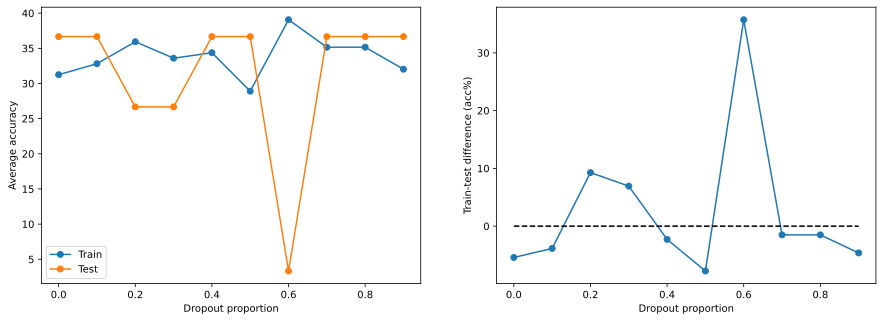

In [10]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Experiments

1. Change the activation function into a different activation function and re-run the code, compare the result with the ReLU activation function. Does different activation function affect the performance of the dropout?

2. Create a wide network using ReLU as the activation function and conduct the same experiment, compare the result to that of the original code.

3. Create a more complex model by adding more layers into the architecture, conduct the same experiment, compare the result to that of the original code.

/tmp/ipython-input-4016731370.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})


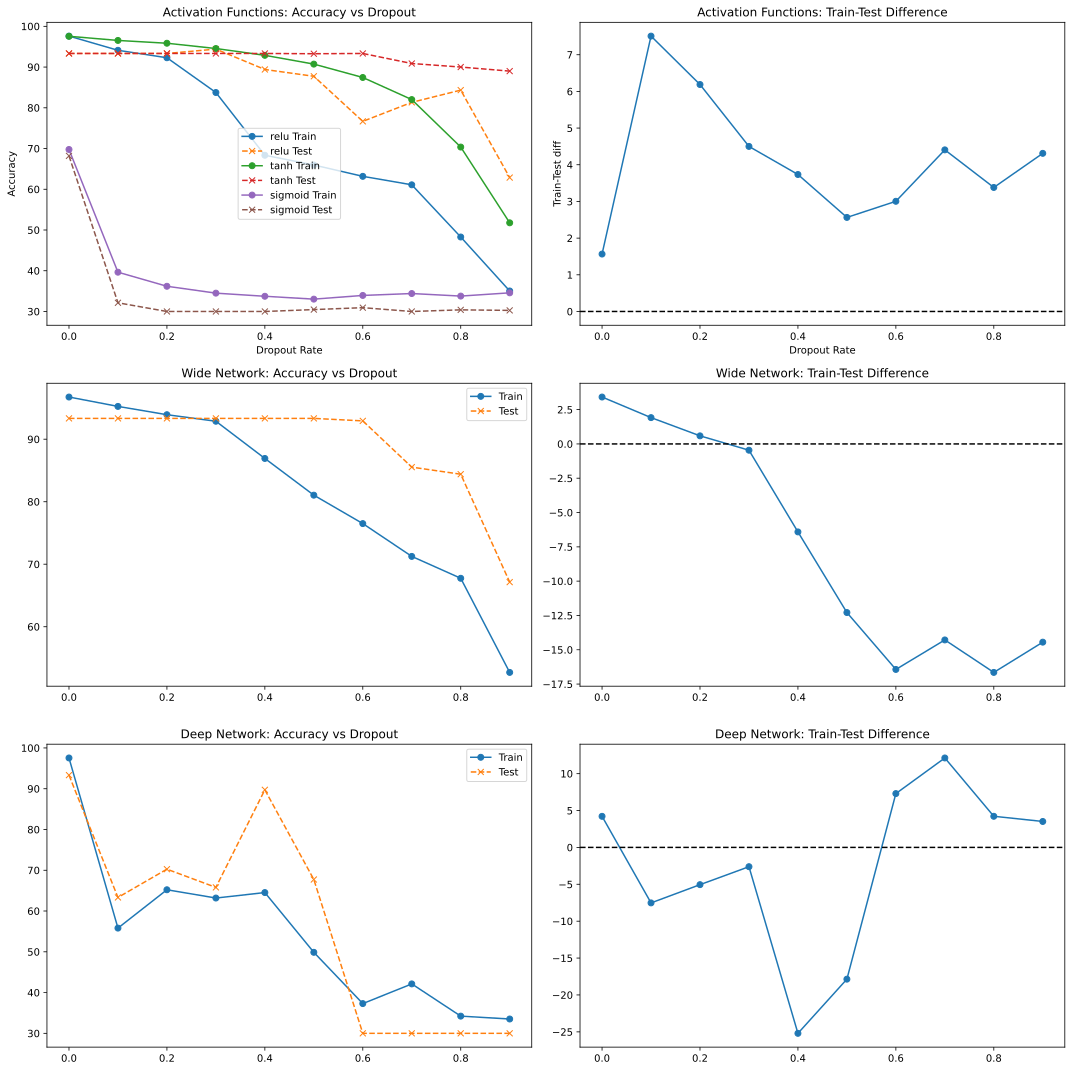

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# Fetch dataset
iris = fetch_ucirepo(id=53)

# Preprocess data
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

# Convert to tensors
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).long()
labels = labels.view(-1,1).squeeze()

# Split into train/test
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

train_dataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataset  = torch.utils.data.TensorDataset(test_data,test_labels)

batchsize = 16
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])


# Experiment 1: Change Activation Function
class ANN_ACTIVATION(nn.Module):
    def __init__(self, dropoutRate, activation='relu'):
        super().__init__()
        self.input  = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)
        self.dr = dropoutRate
        self.activation = activation

    def forward(self,x):
        # Choose activation function dynamically
        if self.activation == 'relu':
            act = F.relu
        elif self.activation == 'tanh':
            act = torch.tanh
        elif self.activation == 'sigmoid':
            act = torch.sigmoid
        else:
            act = F.relu

        x = act(self.input(x))
        x = F.dropout(x,p=self.dr,training=self.training)
        x = act(self.hidden(x))
        x = F.dropout(x,p=self.dr,training=self.training)
        x = self.output(x)
        return x

def ANN_MODEL_ACT(dropoutRate, activation='relu'):
    model = ANN_ACTIVATION(dropoutRate, activation)
    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.005)
    return model, lossfunc, optim


# Training Function
epochs = 1000
def train_model(ANN, lossfunc, optim):
    train_accuracy = []
    test_accuracy = []

    for i in range(epochs):
        ANN.train()
        batch_acc = []
        for X_batch, y_batch in train_loader:
            yHat = ANN(X_batch)
            loss = lossfunc(yHat, y_batch)
            optim.zero_grad()
            loss.backward()
            optim.step()
            batch_acc.append(100*torch.mean((torch.argmax(yHat,1) == y_batch).float()).item())
        train_accuracy.append(np.mean(batch_acc))

        # Test accuracy
        ANN.eval()
        X_test, y_test = next(iter(test_loader))
        pred = torch.argmax(ANN(X_test),1)
        test_accuracy.append(100*torch.mean((pred == y_test).float()).item())

    return train_accuracy, test_accuracy


# Run Experiments
dropoutRates = np.arange(10)/10
activations = ['relu','tanh','sigmoid']

# Store results
results_activation = np.zeros((len(activations), len(dropoutRates), 2))

for a_idx, act in enumerate(activations):
    for d_idx, dr in enumerate(dropoutRates):
        ANN, lossfunc, optim = ANN_MODEL_ACT(dr, activation=act)
        train_acc, test_acc = train_model(ANN, lossfunc, optim)
        results_activation[a_idx, d_idx, 0] = np.mean(train_acc[-50:])
        results_activation[a_idx, d_idx, 1] = np.mean(test_acc[-50:])


# Experiment 2:
class ANN_WIDE(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.input = nn.Linear(4,24)
        self.hidden = nn.Linear(24,24)
        self.output = nn.Linear(24,3)
        self.dr = dropoutRate

    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.output(x)
        return x

def ANN_MODEL_WIDE(dropoutRate):
    model = ANN_WIDE(dropoutRate)
    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.005)
    return model, lossfunc, optim

results_wide = np.zeros((len(dropoutRates),2))
for d_idx, dr in enumerate(dropoutRates):
    ANN, lossfunc, optim = ANN_MODEL_WIDE(dr)
    train_acc, test_acc = train_model(ANN, lossfunc, optim)
    results_wide[d_idx,0] = np.mean(train_acc[-50:])
    results_wide[d_idx,1] = np.mean(test_acc[-50:])


# Experiment 3:
class ANN_DEEP(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.input = nn.Linear(4,12)
        self.hidden1 = nn.Linear(12,12)
        self.hidden2 = nn.Linear(12,12)
        self.hidden3 = nn.Linear(12,12)
        self.output = nn.Linear(12,3)
        self.dr = dropoutRate

    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden1(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden2(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden3(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.output(x)
        return x

def ANN_MODEL_DEEP(dropoutRate):
    model = ANN_DEEP(dropoutRate)
    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.005)
    return model, lossfunc, optim

results_deep = np.zeros((len(dropoutRates),2))
for d_idx, dr in enumerate(dropoutRates):
    ANN, lossfunc, optim = ANN_MODEL_DEEP(dr)
    train_acc, test_acc = train_model(ANN, lossfunc, optim)
    results_deep[d_idx,0] = np.mean(train_acc[-50:])
    results_deep[d_idx,1] = np.mean(test_acc[-50:])

# ==========================
# Plotting results
# ==========================
fig, axes = plt.subplots(3,2, figsize=(15,15))

# Activation experiment
for a_idx, act in enumerate(activations):
    axes[0,0].plot(dropoutRates, results_activation[a_idx,:,0], 'o-', label=f'{act} Train')
    axes[0,0].plot(dropoutRates, results_activation[a_idx,:,1], 'x--', label=f'{act} Test')
axes[0,0].set_title('Activation Functions: Accuracy vs Dropout')
axes[0,0].set_xlabel('Dropout Rate')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()

axes[0,1].plot(dropoutRates, -np.diff(results_activation[a_idx,:,:],axis=1), 'o-')
axes[0,1].axhline(0, color='k', linestyle='--')
axes[0,1].set_title('Activation Functions: Train-Test Difference')
axes[0,1].set_xlabel('Dropout Rate')
axes[0,1].set_ylabel('Train-Test diff')

# Wide network
axes[1,0].plot(dropoutRates, results_wide[:,0], 'o-', label='Train')
axes[1,0].plot(dropoutRates, results_wide[:,1], 'x--', label='Test')
axes[1,0].set_title('Wide Network: Accuracy vs Dropout')
axes[1,0].legend()

axes[1,1].plot(dropoutRates, results_wide[:,0]-results_wide[:,1], 'o-')
axes[1,1].axhline(0,color='k',linestyle='--')
axes[1,1].set_title('Wide Network: Train-Test Difference')

# Deep network
axes[2,0].plot(dropoutRates, results_deep[:,0], 'o-', label='Train')
axes[2,0].plot(dropoutRates, results_deep[:,1], 'x--', label='Test')
axes[2,0].set_title('Deep Network: Accuracy vs Dropout')
axes[2,0].legend()

axes[2,1].plot(dropoutRates, results_deep[:,0]-results_deep[:,1], 'o-')
axes[2,1].axhline(0,color='k',linestyle='--')
axes[2,1].set_title('Deep Network: Train-Test Difference')

plt.tight_layout()
plt.show()
